# Arabic App Review Multi-Label Classification
In this Task, we have about 3000 arabic app review classified into 4 categories
- Bug Report
- Feature Request
- Rating
- Other (Non of the above)

Our goal is to train an NLP model to classify an app review into these 4 Categories 

In [28]:
#import important libraries for this nlp task
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import arabic_reshaper 
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import sentencepiece as spm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam 




# Part B: Multiclass App Review Classification from scratch

# Preprocessing
### Data Cleaning
There are noise text in any textual dataset that should be removed before processing step such as:
- Special Characters (!@#$%^&*)
- URLs (http://........)
- shortcut words (you -> u, are -> r)
- diacritics (حركات) ( ّ ِ ً ٌ َ)
- tatweel (تطويل) (شــــــــكــــــــراً)
- repeated characters (heeeeellllooooo)

Since this is an Arabic NLP task, we chose to use arabic data cleaning library named **tnkeeh (تنقيح)**
as per the github page of the library:
""tnkeeh (تنقيح) is an Arabic preprocessing library for python. It was designed using re for creating quick replacement expressions for several examples.""
it has all the nessasary tools for arabic text cleaning in effective and easy way
- remove_diacritics removes all diacritics.
- remove_special_chars removes all sepcial chars.
- remove_english removes english alphabets and digits.
- normalize match digits that have the same writing but different encodings.
- remove_tatweel tatweel character ـ is used a lot in arabic writing.
- remove_repeated_chars remove characters that appear three times in sequence.
- remove_html_elements remove html elements in the form with their attirbutes.
- remove_links remove links.
- remove_twitter_meta remove twitter mentions, links and hashtags.
- remove_long_words remove words longer than 15 chars.
- by_chunk read files by chunks with size chunk_size.

In [17]:
import tnkeeh

df_mc = pd.read_csv('App Reviews-SingleLabel-Multiclass.csv')
df2 = pd.read_csv('App Reviews-SingleLabel-Multiclass.csv')
tnkeeh.clean_data_frame(df_mc,'review', remove_special_chars = True, 
        remove_english = True, normalize = True, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)
print("Original Data")
display(df2.head())
print("Cleaned Data")
display(df_mc.head())


Original Data


,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others


Cleaned Data


,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابددا ونا دفعت فلوس,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others


In [18]:
df_mc.isnull().sum()
df_mc= df_mc.drop_duplicates()

print('num of null values in each column:')
display(df_mc.isnull().sum())
display(df_mc.shape)

num of null values in each column:


review    0
Label     0
dtype: int64

(2892, 2)

### Data Visualization
In this section, We found the following
- Rating class has the highest count, we may have to do oversampling or undersampling based on the model result
- Most of the ratings are App related reviews. Therefore, the model built here will not work well in of example Website Reviews

C:\Users\aalqa\AppData\Local\Temp\ipykernel_4012\686022856.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_mc, palette='Set2')


Text(0.5, 1.0, 'Class Distributions')

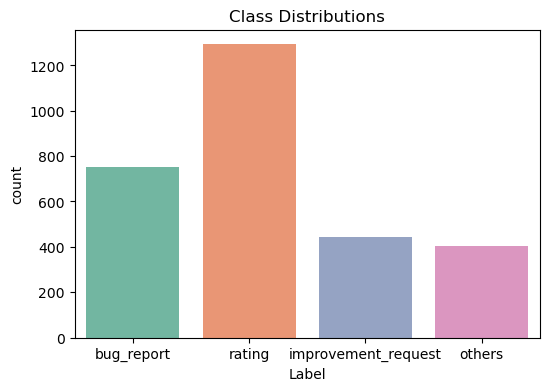

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df_mc, palette='Set2')
plt.title('Class Distributions')

#### Arabic Word Cloud: Credit Given to Arabic Word Clouds From Amjad Khatabi Kuggle
https://www.kaggle.com/code/amjadkhatabi/arabic-word-clouds-text-processing-rendering

In [6]:
#collecting stopwords to discard it from wordcloud
stopwords = pd.read_csv('arabic_dialects_stopwords.csv')["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))

1997


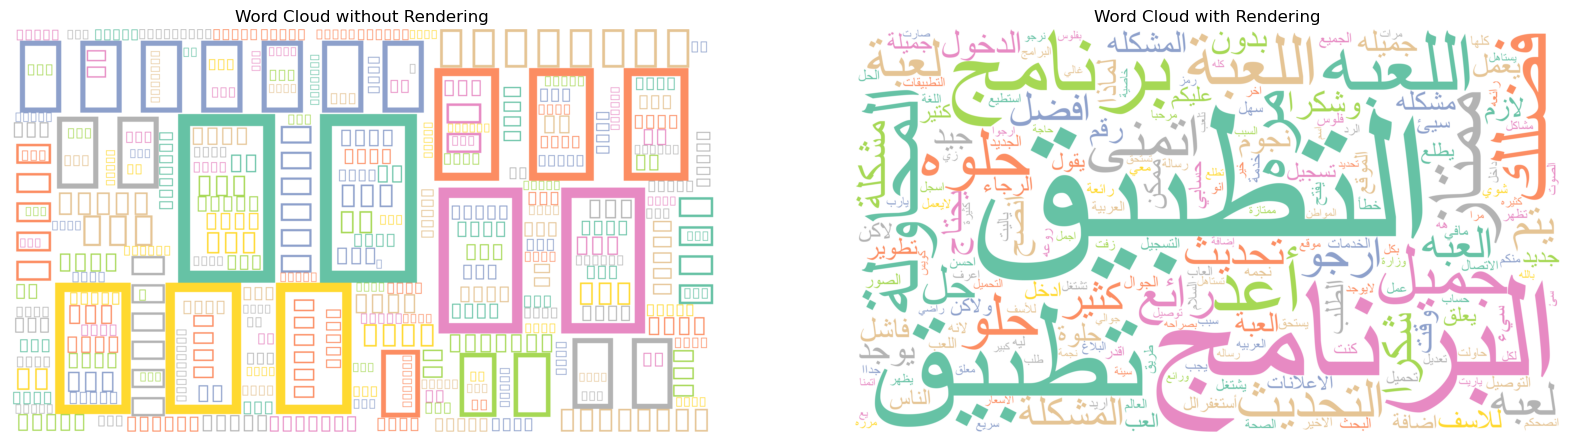

C:\Users\aalqa\AppData\Local\Temp\ipykernel_4012\4127266605.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[0])
C:\Users\aalqa\AppData\Local\Temp\ipykernel_4012\4127266605.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[1])


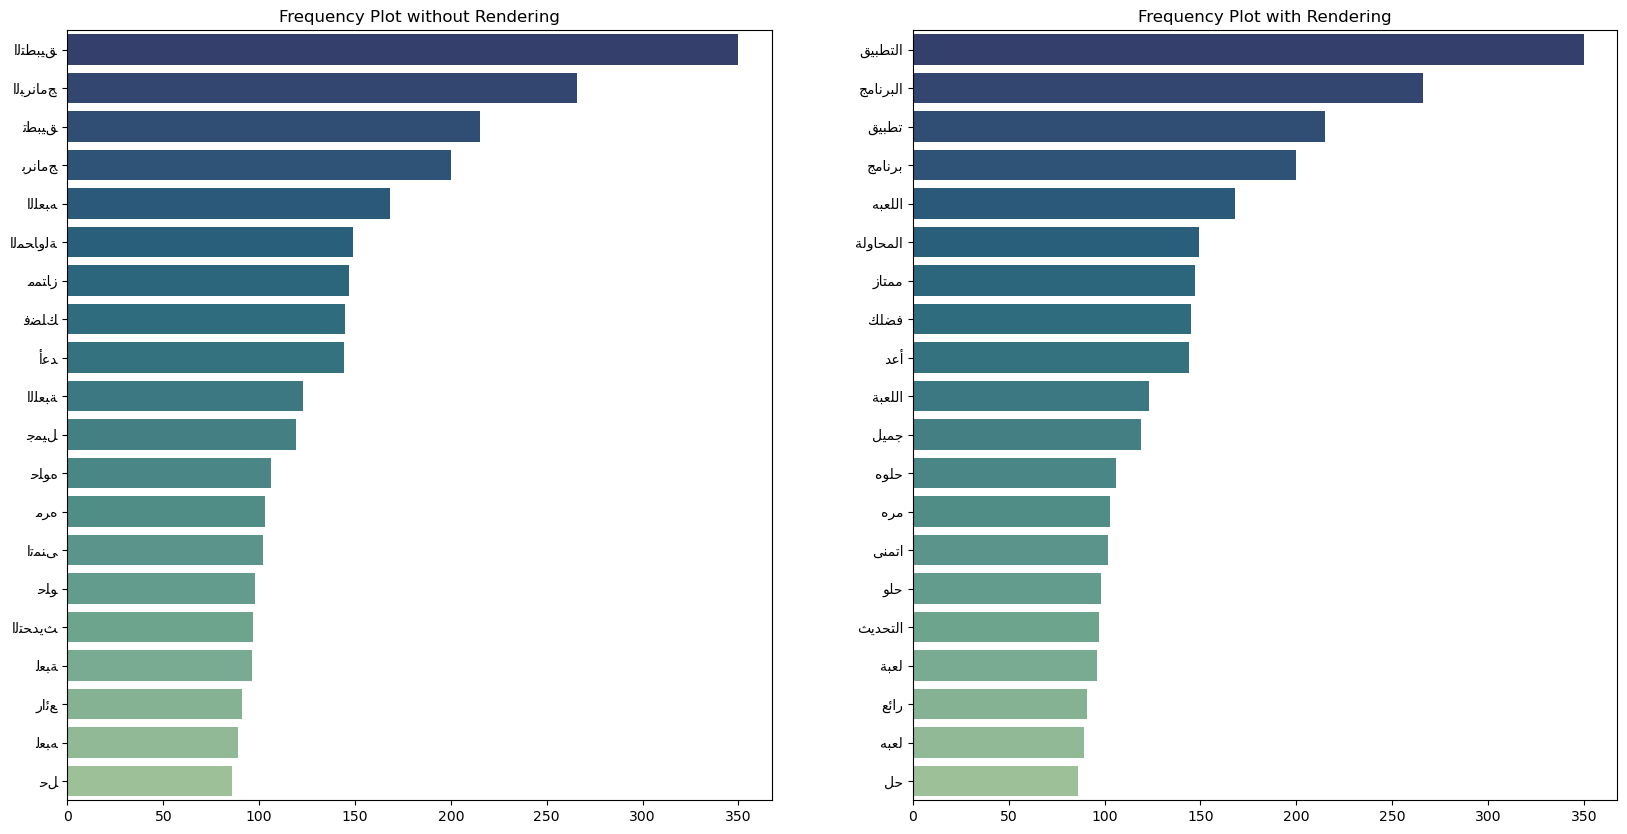

In [7]:
def column_to_wordcloud_with_frequencies_comparison(df, column, font_file, stopwords):

    """
    Parameters:
          df: the dataframe that contains the column 
          column: the name of the column that contains the text 
          font_file: the path to the font file for Arabic characters 
          stopwords: a list of words to exclude from the word cloud and the frequency plot

    Outputs:
          None. The function only displays the word cloud image and the frequency plot, with and without rendering.
    """
    
    # join all the non-null values in the column into a single string
    text = " ".join(t for t in df[column].dropna())

    # reshape and reorder the Arabic text for proper rendering
    reshaped_text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())

    bidi_text=get_display(reshaped_text)
    stopwords_w = [get_display(s) for s in stopwords]

    # create and display the wordcloud with rendering
    wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords_w).generate(bidi_text)

    # create a subplot with two columns
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # display the wordcloud without rendering on the left column
    ax[0].imshow(WordCloud(width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords_w).generate(text), interpolation="bilinear")
    ax[0].axis("off")
    ax[0].set_title("Word Cloud without Rendering")

    # display the wordcloud with rendering on the right column
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis("off")
    ax[1].set_title("Word Cloud with Rendering")
    plt.show()
    
    
    # create and display the frequency plot with rendering
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    counts = Counter(reshaped_text.split())
    counts = {k:v for k,v in counts.items() if k not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])
    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))
    sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[0])
    ax[0].set_title("Frequency Plot without Rendering")

    # display the frequency plot with rendering on the right column
    counts = Counter(reshaped_text.split())
    counts = {get_display(k):v for k,v in counts.items() if k not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])
    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))
    sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[1])

    ax[1].set_title("Frequency Plot with Rendering")

    plt.show()


column_to_wordcloud_with_frequencies_comparison(df_mc, 'review', 'arial.ttf', stopwords = stopwords)

# Training
In this Step we will train a Bidirectional RNN Model to classify the input
But first we need to split the data into training, val, and testing sets
- 80/20 train test split
- 85/15 remaining train val split

In [19]:
train_data, test_data = train_test_split(df_mc, test_size=0.2, stratify= df_mc['Label'], random_state=777) 
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify= train_data['Label'], random_state=777)

In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])
print(tokenizer.word_index)

train_sequences = tokenizer.texts_to_sequences(train_data['review'])
val_sequences = tokenizer.texts_to_sequences(val_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['review'])

print(train_sequences[:5])

{'<OOV>': 1, 'من': 2, 'في': 3, 'جدا': 4, 'بس': 5, 'على': 6, 'التطبيق': 7, 'لا': 8, 'و': 9, 'ما': 10, 'البرنامج': 11, 'المحاولة': 12, 'تطبيق': 13, 'فضلك': 14, 'كل': 15, 'أعد': 16, 'برنامج': 17, 'الله': 18, 'اللعبه': 19, 'ولا': 20, 'ممتاز': 21, 'انا': 22, 'مع': 23, 'هذا': 24, 'فيه': 25, 'ان': 26, 'اللعبة': 27, 'بعد': 28, 'لكن': 29, 'لو': 30, 'جميل': 31, 'او': 32, 'غير': 33, 'حلوه': 34, 'حلو': 35, 'مره': 36, 'اتمنى': 37, 'لعبة': 38, 'اكثر': 39, 'عن': 40, 'لعبه': 41, 'التحديث': 42, 'شي': 43, 'ارجو': 44, 'ولكن': 45, 'يتم': 46, 'لم': 47, 'حل': 48, 'رائع': 49, 'مو': 50, 'الي': 51, 'العبه': 52, 'تحديث': 53, 'يا': 54, 'عندي': 55, 'شكرا': 56, 'فيها': 57, 'يوجد': 58, 'بعض': 59, 'كثير': 60, 'كان': 61, 'يكون': 62, 'الى': 63, 'مشكلة': 64, 'عند': 65, 'لي': 66, 'والله': 67, 'اي': 68, 'افضل': 69, 'المشكلة': 70, 'بدون': 71, 'انه': 72, 'جيد': 73, 'نجوم': 74, 'جميله': 75, 'يعني': 76, 'لكم': 77, 'تم': 78, 'الدخول': 79, 'اللي': 80, 'أن': 81, 'عشان': 82, 'وانا': 83, 'يحتاج': 84, 'كيف': 85, 'حتى': 86, 'المشكل

In [21]:
max_length = max(len(seq) for seq in train_sequences)
print(tokenizer.index_word)

#we don't make maxlen=max_length because we may have more in the unseen test set
train_padded = pad_sequences(train_sequences, maxlen=150, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=150, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=150, padding='post', truncating='post')
print(max_length)
print(train_padded[0])

{1: '<OOV>', 2: 'من', 3: 'في', 4: 'جدا', 5: 'بس', 6: 'على', 7: 'التطبيق', 8: 'لا', 9: 'و', 10: 'ما', 11: 'البرنامج', 12: 'المحاولة', 13: 'تطبيق', 14: 'فضلك', 15: 'كل', 16: 'أعد', 17: 'برنامج', 18: 'الله', 19: 'اللعبه', 20: 'ولا', 21: 'ممتاز', 22: 'انا', 23: 'مع', 24: 'هذا', 25: 'فيه', 26: 'ان', 27: 'اللعبة', 28: 'بعد', 29: 'لكن', 30: 'لو', 31: 'جميل', 32: 'او', 33: 'غير', 34: 'حلوه', 35: 'حلو', 36: 'مره', 37: 'اتمنى', 38: 'لعبة', 39: 'اكثر', 40: 'عن', 41: 'لعبه', 42: 'التحديث', 43: 'شي', 44: 'ارجو', 45: 'ولكن', 46: 'يتم', 47: 'لم', 48: 'حل', 49: 'رائع', 50: 'مو', 51: 'الي', 52: 'العبه', 53: 'تحديث', 54: 'يا', 55: 'عندي', 56: 'شكرا', 57: 'فيها', 58: 'يوجد', 59: 'بعض', 60: 'كثير', 61: 'كان', 62: 'يكون', 63: 'الى', 64: 'مشكلة', 65: 'عند', 66: 'لي', 67: 'والله', 68: 'اي', 69: 'افضل', 70: 'المشكلة', 71: 'بدون', 72: 'انه', 73: 'جيد', 74: 'نجوم', 75: 'جميله', 76: 'يعني', 77: 'لكم', 78: 'تم', 79: 'الدخول', 80: 'اللي', 81: 'أن', 82: 'عشان', 83: 'وانا', 84: 'يحتاج', 85: 'كيف', 86: 'حتى', 87: 'ال

In [11]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Label'])
val_labels = label_encoder.transform(val_data['Label'])
test_labels = label_encoder.transform(test_data['Label'])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'bug_report': 0, 'improvement_request': 1, 'others': 2, 'rating': 3}


### Training the Embedding From Scratch

In [12]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=150),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  
])

model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 256)               197632    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 854340 (3.26 MB)
Trainable params: 854340 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_padded, 
    train_labels, 
    validation_data=(val_padded, val_labels), 
    class_weight=class_weights,
    epochs=5, 
    batch_size=32
)

Epoch 1/5
62/62 [==============================] - 19s 190ms/step - loss: 1.2404 - accuracy: 0.4752 - val_loss: 0.9775 - val_accuracy: 0.6034
Epoch 2/5
62/62 [==============================] - 10s 156ms/step - loss: 0.5444 - accuracy: 0.8068 - val_loss: 1.0552 - val_accuracy: 0.6207
Epoch 3/5
62/62 [==============================] - 11s 170ms/step - loss: 0.1899 - accuracy: 0.9397 - val_loss: 1.2123 - val_accuracy: 0.6178
Epoch 4/5
62/62 [==============================] - 10s 167ms/step - loss: 0.0657 - accuracy: 0.9777 - val_loss: 1.5869 - val_accuracy: 0.6351
Epoch 5/5
62/62 [==============================] - 12s 188ms/step - loss: 0.0485 - accuracy: 0.9843 - val_loss: 1.9905 - val_accuracy: 0.6351


In [ ]:
predictions = model.predict(val_padded[:10])
print(predictions)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)
label_encoder.inverse_transform(predicted_classes)

1/1 [==============================] - 2s 2s/step
[[9.97828782e-01 5.88152383e-04 6.43771607e-04 9.39292775e-04]
 [4.05969011e-04 1.65435195e-04 2.15510977e-03 9.97273386e-01]
 [2.49296081e-05 9.99909997e-01 2.46813283e-06 6.25944303e-05]
 [7.86101539e-03 3.44057940e-03 1.04324974e-03 9.87655222e-01]
 [1.16513386e-01 8.99068825e-03 2.54758187e-02 8.49020064e-01]
 [5.58020592e-01 8.91903136e-03 4.21706229e-01 1.13541586e-02]
 [4.85493988e-01 2.80406680e-02 4.73284125e-01 1.31812254e-02]
 [4.72590094e-03 3.66220280e-04 9.94826138e-01 8.17059190e-05]
 [4.02083665e-01 1.06703766e-01 7.10044289e-03 4.84112144e-01]
 [9.50528264e-01 3.41343693e-03 9.76210181e-03 3.62961143e-02]]
[0 3 1 3 3 0 0 2 3 0]


array(['bug_report', 'rating', 'improvement_request', 'rating', 'rating',
       'bug_report', 'bug_report', 'others', 'rating', 'bug_report'],
      dtype=object)

### Model 1 Performance On Test Set

19/19 [==============================] - 1s 75ms/step
[[ 96   5  13  37]
 [ 11  42   9  26]
 [ 16   6  39  20]
 [ 29  19  20 192]]
                     precision    recall  f1-score   support

         bug_report       0.63      0.64      0.63       151
improvement_request       0.58      0.48      0.53        88
             others       0.48      0.48      0.48        81
             rating       0.70      0.74      0.72       260

           accuracy                           0.64       580
          macro avg       0.60      0.58      0.59       580
       weighted avg       0.63      0.64      0.63       580



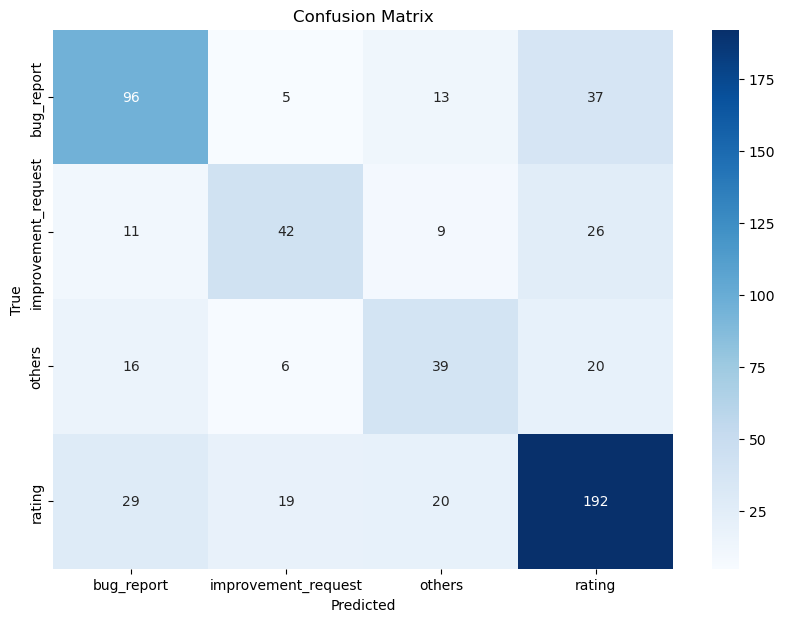

In [ ]:
model.evaluate(test_padded, test_labels)
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_classes)
prediction_report = classification_report(test_labels, predicted_classes, target_names=label_encoder.classes_)
print(conf_matrix)
print(prediction_report)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Word2Vec Embedding
here we will use "AraVec" Word embedding for Arabic words which is integrated with gensim Library for Word2Vec

In [22]:
from gensim.models import Word2Vec
t_model = Word2Vec.load("www_cbow_100")

#test for pre-trained word2vec performance
display(t_model.wv.most_similar( "اهلا", topn=10))
#print the length of the embedding
print(len(t_model.wv["اهلا"]))

word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

# Build the embedding matrix
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in t_model.wv:
        embedding_matrix[i] = t_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))

print(embedding_matrix.shape)

[('مرحبا', 0.8243391513824463),
 ('وسهلا', 0.8131280541419983),
 ('وبركاتهاهلا', 0.7789369225502014),
 ('ومرحبا', 0.7635677456855774),
 ('نرحب', 0.727516770362854),
 ('وبركاتهمرحبا', 0.7010937929153442),
 ('المنتدياهلا', 0.7010261416435242),
 ('واهلا', 0.6718873381614685),
 ('يرحب', 0.6648346185684204),
 ('فاهلا', 0.662208616733551)]

100
(8678, 100)


In [36]:
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=100,weights=[embedding_matrix], input_length=150,trainable=False),
    Bidirectional(LSTM(256,dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          867800    
                                                                 
 bidirectional_14 (Bidirect  (None, 150, 512)          731136    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 150, 512)          0         
                                                                 
 global_average_pooling1d_3  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 64)               

In [37]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   classes=np.unique(train_labels),
#                                                   y=train_labels)
# class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_padded, 
    train_labels, 
    validation_data=(val_padded, val_labels), 
    class_weight=class_weights,
    epochs=5, 
    batch_size=16
)

Epoch 1/5
123/123 [==============================] - 55s 326ms/step - loss: 1.3475 - accuracy: 0.4145 - val_loss: 1.2790 - val_accuracy: 0.4352
Epoch 2/5
123/123 [==============================] - 38s 311ms/step - loss: 1.1897 - accuracy: 0.5137 - val_loss: 1.0718 - val_accuracy: 0.5562
Epoch 3/5
123/123 [==============================] - 37s 300ms/step - loss: 1.0470 - accuracy: 0.5753 - val_loss: 1.0259 - val_accuracy: 0.5591
Epoch 4/5
123/123 [==============================] - 37s 299ms/step - loss: 0.9727 - accuracy: 0.6043 - val_loss: 0.9795 - val_accuracy: 0.5821
Epoch 5/5
123/123 [==============================] - 43s 350ms/step - loss: 0.8898 - accuracy: 0.6277 - val_loss: 0.9911 - val_accuracy: 0.6225


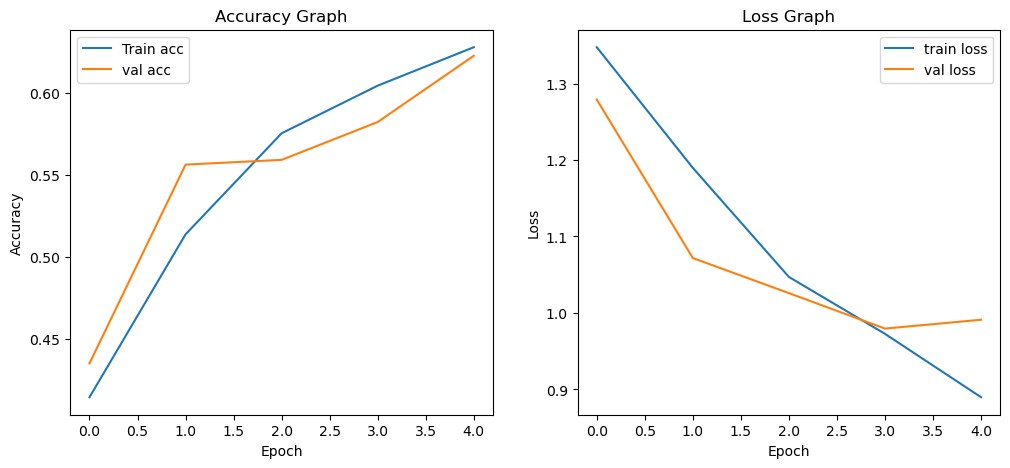

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


19/19 [==============================] - 3s 99ms/step
[[121  11  12   7]
 [ 27  40  10  11]
 [ 19   5  49   8]
 [ 29  50  20 160]]
                     precision    recall  f1-score   support

         bug_report       0.62      0.80      0.70       151
improvement_request       0.38      0.45      0.41        88
             others       0.54      0.60      0.57        81
             rating       0.86      0.62      0.72       259

           accuracy                           0.64       579
          macro avg       0.60      0.62      0.60       579
       weighted avg       0.68      0.64      0.65       579



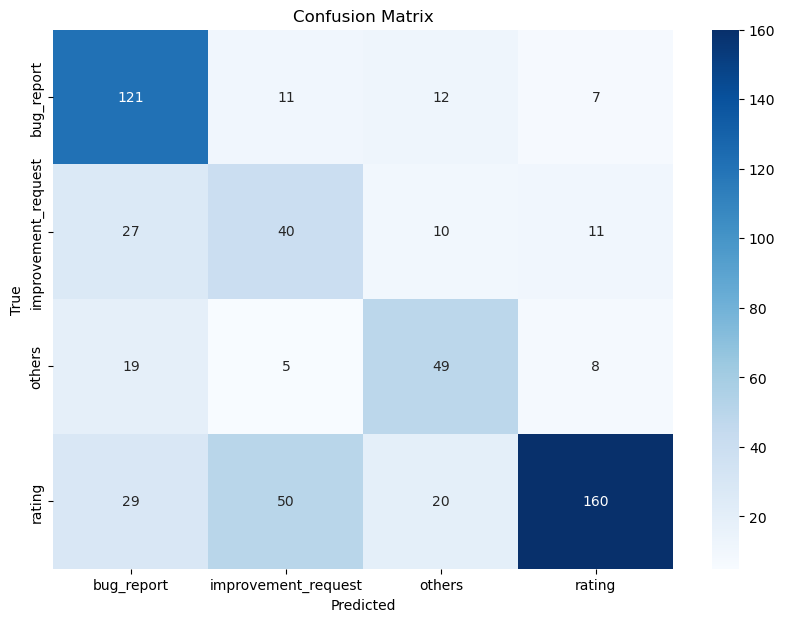

In [39]:
model.evaluate(test_padded, test_labels)
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_classes)
prediction_report = classification_report(test_labels, predicted_classes, target_names=label_encoder.classes_)
print(conf_matrix)
print(prediction_report)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Part C: Multilabel App Review Classification: from scratch

In [40]:
df_ml = pd.read_csv('App Reviews-Multilabel.csv')
tnkeeh.clean_data_frame(df_ml,'review', remove_special_chars = True, 
        remove_english = True, normalize = True, remove_diacritics = True,
        excluded_chars = [], remove_tatweel = True, remove_html_elements = True,
        remove_links = True, remove_twitter_meta = True, remove_long_words = True,
        remove_repeated_chars = True)


,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابددا ونا دفعت فلوس,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1
...,...,...,...,...,...
2895,بكل حياديه وتجرد انقل تجربتي التطبيق جميل جدا ...,1,1,1,0
2896,مررة صار معفن مدري الا بالقوة بيدخلنا موقعهم ه...,1,0,1,0
2897,لابد من تطويره ليستفاد منو الجميع,0,1,1,0
2898,تطبيق اكثر من رائع ومجهود مبارك ننتظر المزيد ل...,0,1,1,0


In [41]:
df_ml.isnull().sum()
df_ml= df_ml.drop_duplicates()

print('num of null values in each column:')
display(df_ml.isnull().sum())
display(df_ml.shape)

num of null values in each column:


review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

(2893, 5)

### Data Visualization
In this section, We found the following
- Rating class has the highest count, we may have to do oversampling or undersampling based on the model result
- Most of the ratings are App related reviews. Therefore, the model built here will not work well in of example Website Reviews

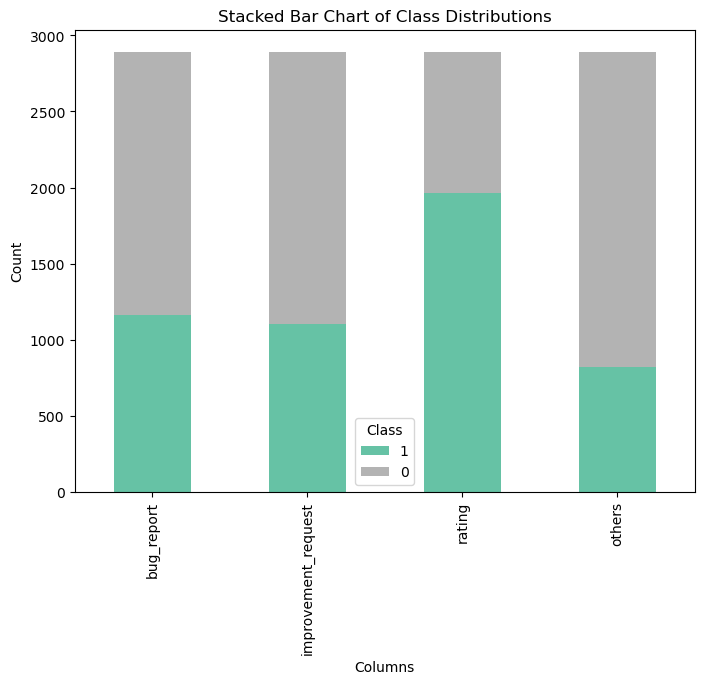

occurrence matrix:


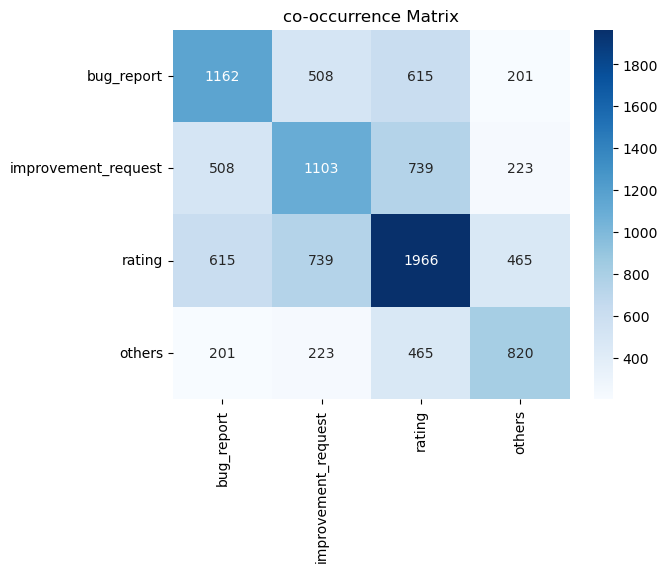

In [42]:
#class count plot
class_counts = df_ml.iloc[:,1:].apply(lambda x: x.value_counts()).reindex([1, 0])
class_counts.T.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Set2')
plt.title('Stacked Bar Chart of Class Distributions')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()

#co-occurance plot 
labels_df = df_ml.iloc[:, 1:]
cols = labels_df.columns
cooccur_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        cooccur_matrix.loc[col1, col2] = ((labels_df[col1] == 1) & (labels_df[col2] == 1)).sum()
print("occurrence matrix:")
sns.heatmap(cooccur_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('co-occurrence Matrix')
plt.show()

In [ ]:
#collecting stopwords to discard it from wordcloud
stopwords = pd.read_csv('arabic_dialects_stopwords.csv')["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))

1997


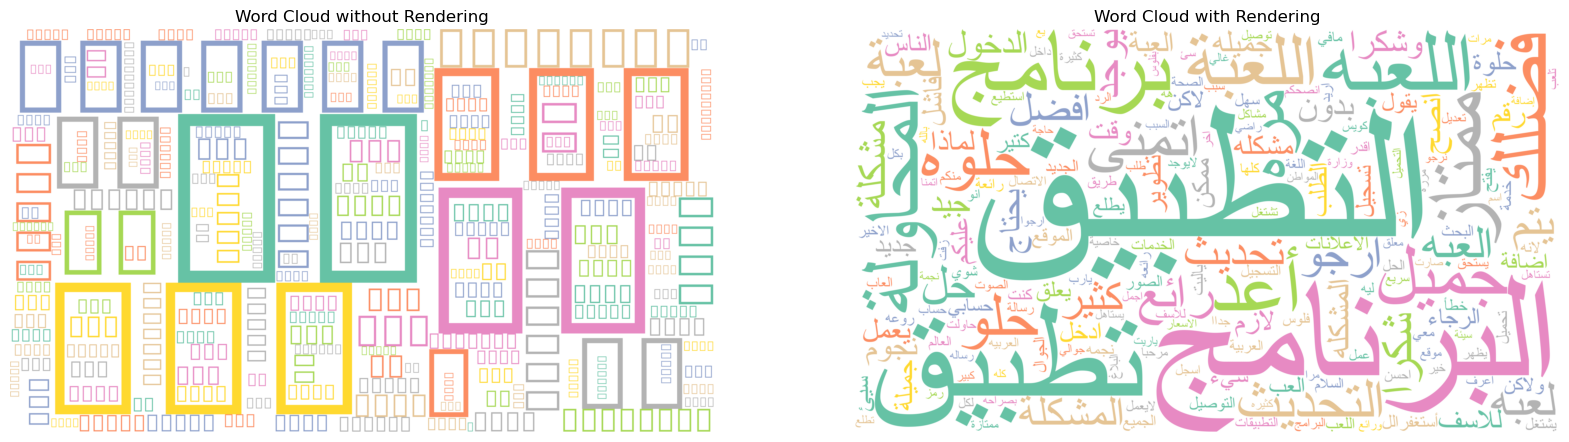

C:\Users\aalqa\AppData\Local\Temp\ipykernel_27232\2106380764.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[0])
C:\Users\aalqa\AppData\Local\Temp\ipykernel_27232\2106380764.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[1])


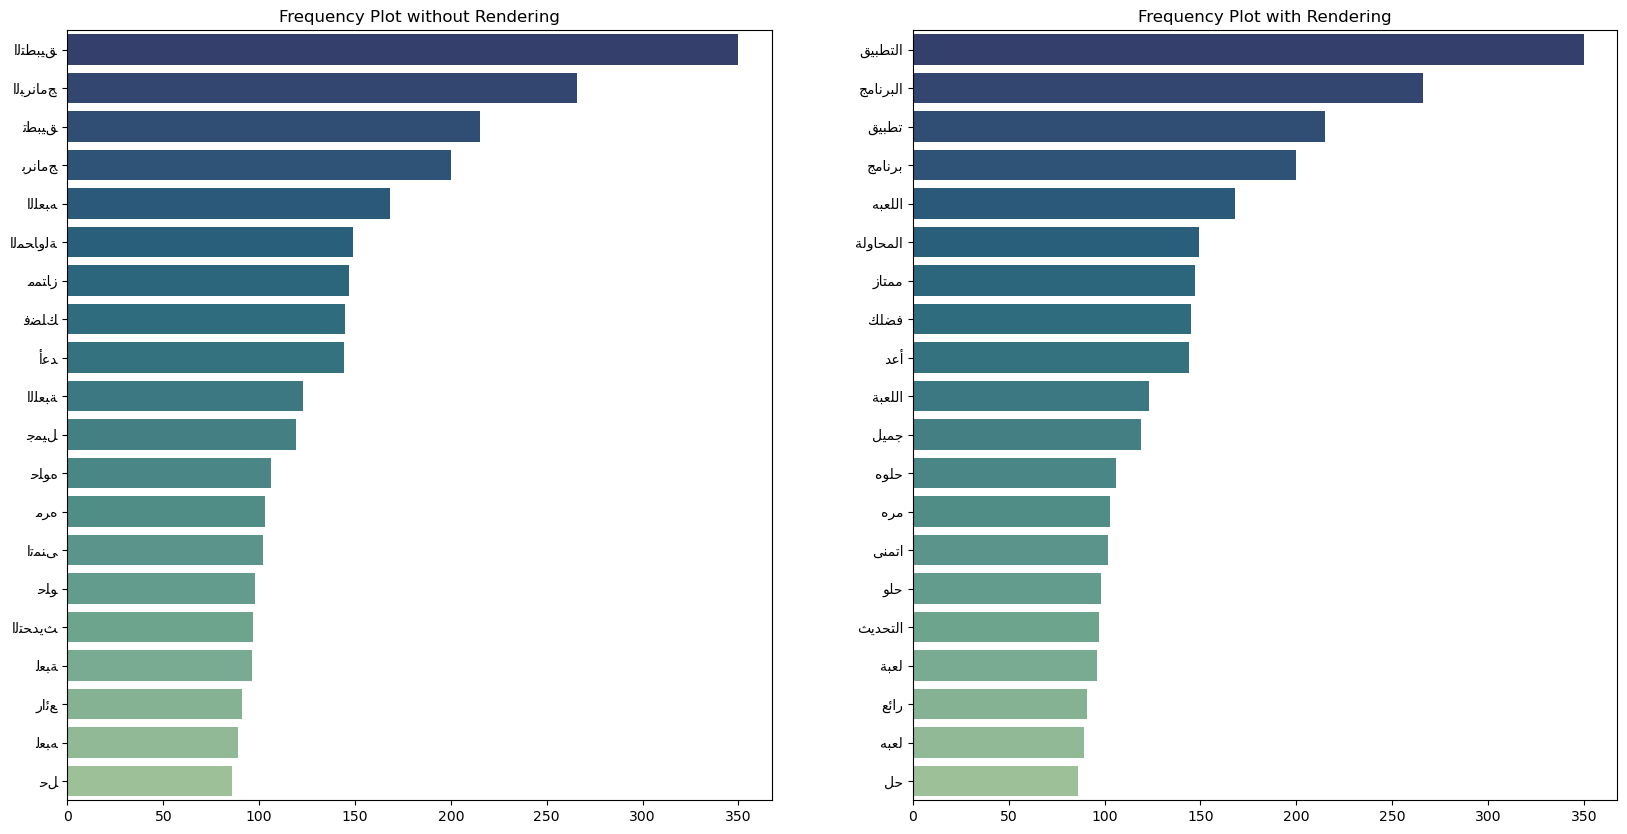

In [ ]:
def column_to_wordcloud_with_frequencies_comparison(df, column, font_file, stopwords):

    """
    Parameters:
          df: the dataframe that contains the column 
          column: the name of the column that contains the text 
          font_file: the path to the font file for Arabic characters 
          stopwords: a list of words to exclude from the word cloud and the frequency plot

    Outputs:
          None. The function only displays the word cloud image and the frequency plot, with and without rendering.
    """
    
    # join all the non-null values in the column into a single string
    text = " ".join(t for t in df[column].dropna())

    # reshape and reorder the Arabic text for proper rendering
    reshaped_text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())

    bidi_text=get_display(reshaped_text)
    stopwords_w = [get_display(s) for s in stopwords]

    # create and display the wordcloud with rendering
    wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords_w).generate(bidi_text)

    # create a subplot with two columns
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # display the wordcloud without rendering on the left column
    ax[0].imshow(WordCloud(width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords_w).generate(text), interpolation="bilinear")
    ax[0].axis("off")
    ax[0].set_title("Word Cloud without Rendering")

    # display the wordcloud with rendering on the right column
    ax[1].imshow(wordcloud, interpolation="bilinear")
    ax[1].axis("off")
    ax[1].set_title("Word Cloud with Rendering")
    plt.show()
    
    
    # create and display the frequency plot with rendering
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    counts = Counter(reshaped_text.split())
    counts = {k:v for k,v in counts.items() if k not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])
    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))
    sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[0])
    ax[0].set_title("Frequency Plot without Rendering")

    # display the frequency plot with rendering on the right column
    counts = Counter(reshaped_text.split())
    counts = {get_display(k):v for k,v in counts.items() if k not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])
    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))
    sns.barplot(y= list(counts.keys()), x=list(counts.values()), palette=palette,ax=ax[1])

    ax[1].set_title("Frequency Plot with Rendering")

    plt.show()


column_to_wordcloud_with_frequencies_comparison(df_ml, 'review', 'arial.ttf', stopwords = stopwords)

# Training
### From Scrach
For Multilabel dataset, we cant use stratify like usual, <br>
<br>
idea:
<br>
stratify based on the least present label on the set since it will be most affected by unbalanced split which will be others.
<br>
<br>
but we dont really care about others label much like the other label so we will split based on the second least present label. which is **improvement_request**

In [46]:
train_data, test_data = train_test_split(df_ml, test_size=0.2, stratify= df_ml['improvement_request'], random_state=777) 
train_data, val_data = train_test_split(train_data, test_size=0.15, stratify= train_data['improvement_request'], random_state=777)

In [47]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])
print(tokenizer.word_index)

train_sequences = tokenizer.texts_to_sequences(train_data['review'])
val_sequences = tokenizer.texts_to_sequences(val_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['review'])

print(train_sequences[:5])

{'<OOV>': 1, 'من': 2, 'في': 3, 'جدا': 4, 'على': 5, 'بس': 6, 'التطبيق': 7, 'و': 8, 'لا': 9, 'ما': 10, 'البرنامج': 11, 'تطبيق': 12, 'المحاولة': 13, 'فضلك': 14, 'أعد': 15, 'كل': 16, 'الله': 17, 'برنامج': 18, 'ولا': 19, 'اللعبه': 20, 'انا': 21, 'ممتاز': 22, 'فيه': 23, 'ان': 24, 'مع': 25, 'اللعبة': 26, 'هذا': 27, 'لو': 28, 'بعد': 29, 'لعبة': 30, 'التحديث': 31, 'لكن': 32, 'جميل': 33, 'اتمنى': 34, 'حلو': 35, 'حل': 36, 'او': 37, 'تحديث': 38, 'حلوه': 39, 'شي': 40, 'غير': 41, 'رائع': 42, 'عن': 43, 'مو': 44, 'الي': 45, 'مره': 46, 'ارجو': 47, 'عند': 48, 'لعبه': 49, 'العبه': 50, 'اكثر': 51, 'يكون': 52, 'كان': 53, 'يتم': 54, 'لي': 55, 'شكرا': 56, 'المشكلة': 57, 'والله': 58, 'ولكن': 59, 'فيها': 60, 'بعض': 61, 'بدون': 62, 'لم': 63, 'المشكله': 64, 'الى': 65, 'كثير': 66, 'وشكرا': 67, 'مشكلة': 68, 'يحتاج': 69, 'جيد': 70, 'لكم': 71, 'اي': 72, 'تم': 73, 'افضل': 74, 'نجوم': 75, 'انصح': 76, 'يا': 77, 'انه': 78, 'أن': 79, 'ليش': 80, 'اللي': 81, 'حتى': 82, 'اذا': 83, 'يعني': 84, 'الدخول': 85, 'مثل': 86, 'العبة

In [66]:
max_length = max(len(seq) for seq in train_sequences)
print(tokenizer.index_word)

#we don't make maxlen=max_length because we may have more in the unseen test set
train_padded = pad_sequences(train_sequences, maxlen=150, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=150, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=150, padding='post', truncating='post')
print(max_length)
print(train_padded[0])

{1: '<OOV>', 2: 'من', 3: 'في', 4: 'جدا', 5: 'على', 6: 'بس', 7: 'التطبيق', 8: 'و', 9: 'لا', 10: 'ما', 11: 'البرنامج', 12: 'تطبيق', 13: 'المحاولة', 14: 'فضلك', 15: 'أعد', 16: 'كل', 17: 'الله', 18: 'برنامج', 19: 'ولا', 20: 'اللعبه', 21: 'انا', 22: 'ممتاز', 23: 'فيه', 24: 'ان', 25: 'مع', 26: 'اللعبة', 27: 'هذا', 28: 'لو', 29: 'بعد', 30: 'لعبة', 31: 'التحديث', 32: 'لكن', 33: 'جميل', 34: 'اتمنى', 35: 'حلو', 36: 'حل', 37: 'او', 38: 'تحديث', 39: 'حلوه', 40: 'شي', 41: 'غير', 42: 'رائع', 43: 'عن', 44: 'مو', 45: 'الي', 46: 'مره', 47: 'ارجو', 48: 'عند', 49: 'لعبه', 50: 'العبه', 51: 'اكثر', 52: 'يكون', 53: 'كان', 54: 'يتم', 55: 'لي', 56: 'شكرا', 57: 'المشكلة', 58: 'والله', 59: 'ولكن', 60: 'فيها', 61: 'بعض', 62: 'بدون', 63: 'لم', 64: 'المشكله', 65: 'الى', 66: 'كثير', 67: 'وشكرا', 68: 'مشكلة', 69: 'يحتاج', 70: 'جيد', 71: 'لكم', 72: 'اي', 73: 'تم', 74: 'افضل', 75: 'نجوم', 76: 'انصح', 77: 'يا', 78: 'انه', 79: 'أن', 80: 'ليش', 81: 'اللي', 82: 'حتى', 83: 'اذا', 84: 'يعني', 85: 'الدخول', 86: 'مثل', 87: 'ا

In [67]:
train_labels = train_data.iloc[:, 1:].to_numpy(dtype=np.float32)
val_labels = val_data.iloc[:, 1:].to_numpy(dtype=np.float32)
test_labels = test_data.iloc[:, 1:].to_numpy(dtype=np.float32)
print(test_labels.shape)
print(train_padded.shape)

(579, 4)
(1966, 150)


Since This is multiLabel Task, we will change from softmax (sum of all probabilities = 1) to sigmoid (probability that a indivisual class = 1)

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=150),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 150, 64)           640000    
                                                                 
 bidirectional_25 (Bidirect  (None, 150, 512)          657408    
 ional)                                                          
                                                                 
 dropout_29 (Dropout)        (None, 150, 512)          0         
                                                                 
 bidirectional_26 (Bidirect  (None, 256)               656384    
 ional)                                                          
                                                                 
 dense_38 (Dense)            (None, 64)                16448     
                                                                 
 dense_39 (Dense)            (None, 4)               

In [87]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   classes=np.unique(train_labels),
#                                                   y=train_labels)
history = model.fit(
    train_padded, 
    train_labels, 
    validation_data=(val_padded, val_labels), 
    epochs=10, 
    batch_size=32
)

Epoch 1/10
62/62 [==============================] - 70s 981ms/step - loss: 0.2645 - accuracy: 0.3352 - val_loss: 0.2546 - val_accuracy: 0.3822
Epoch 2/10
62/62 [==============================] - 66s 1s/step - loss: 0.2129 - accuracy: 0.5916 - val_loss: 0.2560 - val_accuracy: 0.4023
Epoch 3/10
62/62 [==============================] - 74s 1s/step - loss: 0.1469 - accuracy: 0.6775 - val_loss: 0.2524 - val_accuracy: 0.5402
Epoch 4/10
62/62 [==============================] - 69s 1s/step - loss: 0.0883 - accuracy: 0.7223 - val_loss: 0.3242 - val_accuracy: 0.5374
Epoch 5/10
62/62 [==============================] - 70s 1s/step - loss: 0.0473 - accuracy: 0.7330 - val_loss: 0.3987 - val_accuracy: 0.5603
Epoch 6/10
 6/62 [=>............................] - ETA: 1:02 - loss: 0.0296 - accuracy: 0.6667

KeyboardInterrupt: 

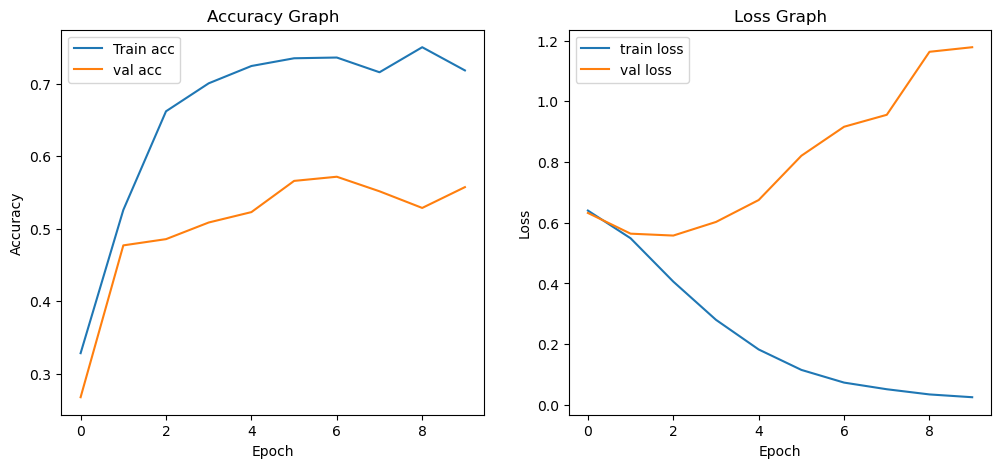

In [77]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
